# Clustering, técnicas de agrupamiento

## Autor:
MARTINEZ GORDON RONIE

#### Trabajo presentado como actividad propuesta para la asignatura "Aprendizaje Automático"

## Objetivo
Aplicar e interpretar los resultados de un algoritmo de Clustering aplicado sobre el conjunto de datos. Se recomienda la aplicación del algoritmo K-MEANS.

## Información sobre los datos
El enlace: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers contiene la información necesaria sobre los datos.
Los datos tratan información relacionada con características de productos.

#### Pasos a seguir (orientativo)
- Análisis descriptivo de los datos
- Determinar el conjunto de modelización y el de validación
- Tratamiento de missing
- Calcular las métricas de evaluación de ajuste adecuadas
- Comentar los resultados obtenidos
- Otros comentarios que parezcan adecuados

## Inspección de los datos y pre-procesamiento

### Importamos las librerías necesarias

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [1]:
import numpy as np
import pandas as pd

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from sklearn import metrics

# KMeans
from sklearn.cluster import KMeans

### Cargamos el dataset
El conjunto de datos se refiere a los clientes de un distribuidor mayorista. Incluye el gasto anual en unidades monetarias (m.u.) en diversas categorías de productos

#### Attribute Information:

- FRESH: annual spending (m.u.) on fresh products (Continuous); 
- MILK: annual spending (m.u.) on milk products (Continuous); 
- GROCERY: annual spending (m.u.)on grocery products (Continuous); 
- FROZEN: annual spending (m.u.)on frozen products (Continuous) 
- DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous) 
- DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous); 
- CHANNEL: customers Channel - Horeca (Hotel/Restaurant/Café) or Retail channel (Nominal) 
- REGION: customers Region Lisnon, Oporto or Other (Nominal) 

In [2]:
# Cargamos nuestro dataset con información por horas
nombre_csv = 'Wholesale_customers_data.csv'
raw_data = pd.read_csv(nombre_csv)
print("Tamaño del dataset: ",raw_data.shape)
display(raw_data.head())
display(raw_data.tail())

Tamaño del dataset:  (440, 8)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125
439,1,3,2787,1698,2510,65,477,52


### Tratamiento de missing y variables categóricas

In [3]:
# Verificamos que no haya valores missing
print(raw_data.isna().sum()) # cantidad de datos no válidos

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


No existen valores missing.

Se podría realizar un proceso de _one-hot encoding_ para las variables categóricas, pero por la naturaleza de estas (y en base a pruebas realizadas, no existe mayor diferencia).

In [4]:
# eliminamos las columnas que se consideran innecesarias: 
#raw_data.pop('Channel');
#raw_data.pop('Region');

### Determinar el conjunto de modelización y el de validación

Para el proceso de "_hold-out_" se recomienda una relación de 80% - 20% entre el _training set_ y el _test set_. Adicionalmente es recomendable realizarlo de manera aleatoria debido a que se desconoce la naturaleza de la obtención de los datos.

In [5]:
dataset = raw_data.copy()
# Split data
train_ds = dataset.sample(frac=0.8, random_state=0)
print("Training dataset shape: ",train_ds.shape)
test_ds = dataset.drop(train_ds.index)
print("Test dataset shape: ",test_ds.shape)

Training dataset shape:  (352, 8)
Test dataset shape:  (88, 8)


### Inspección de los datos

Como herramienta para visualización, podemos graficar la distribución conjunta y relación entre algunos atributos del _dataset_

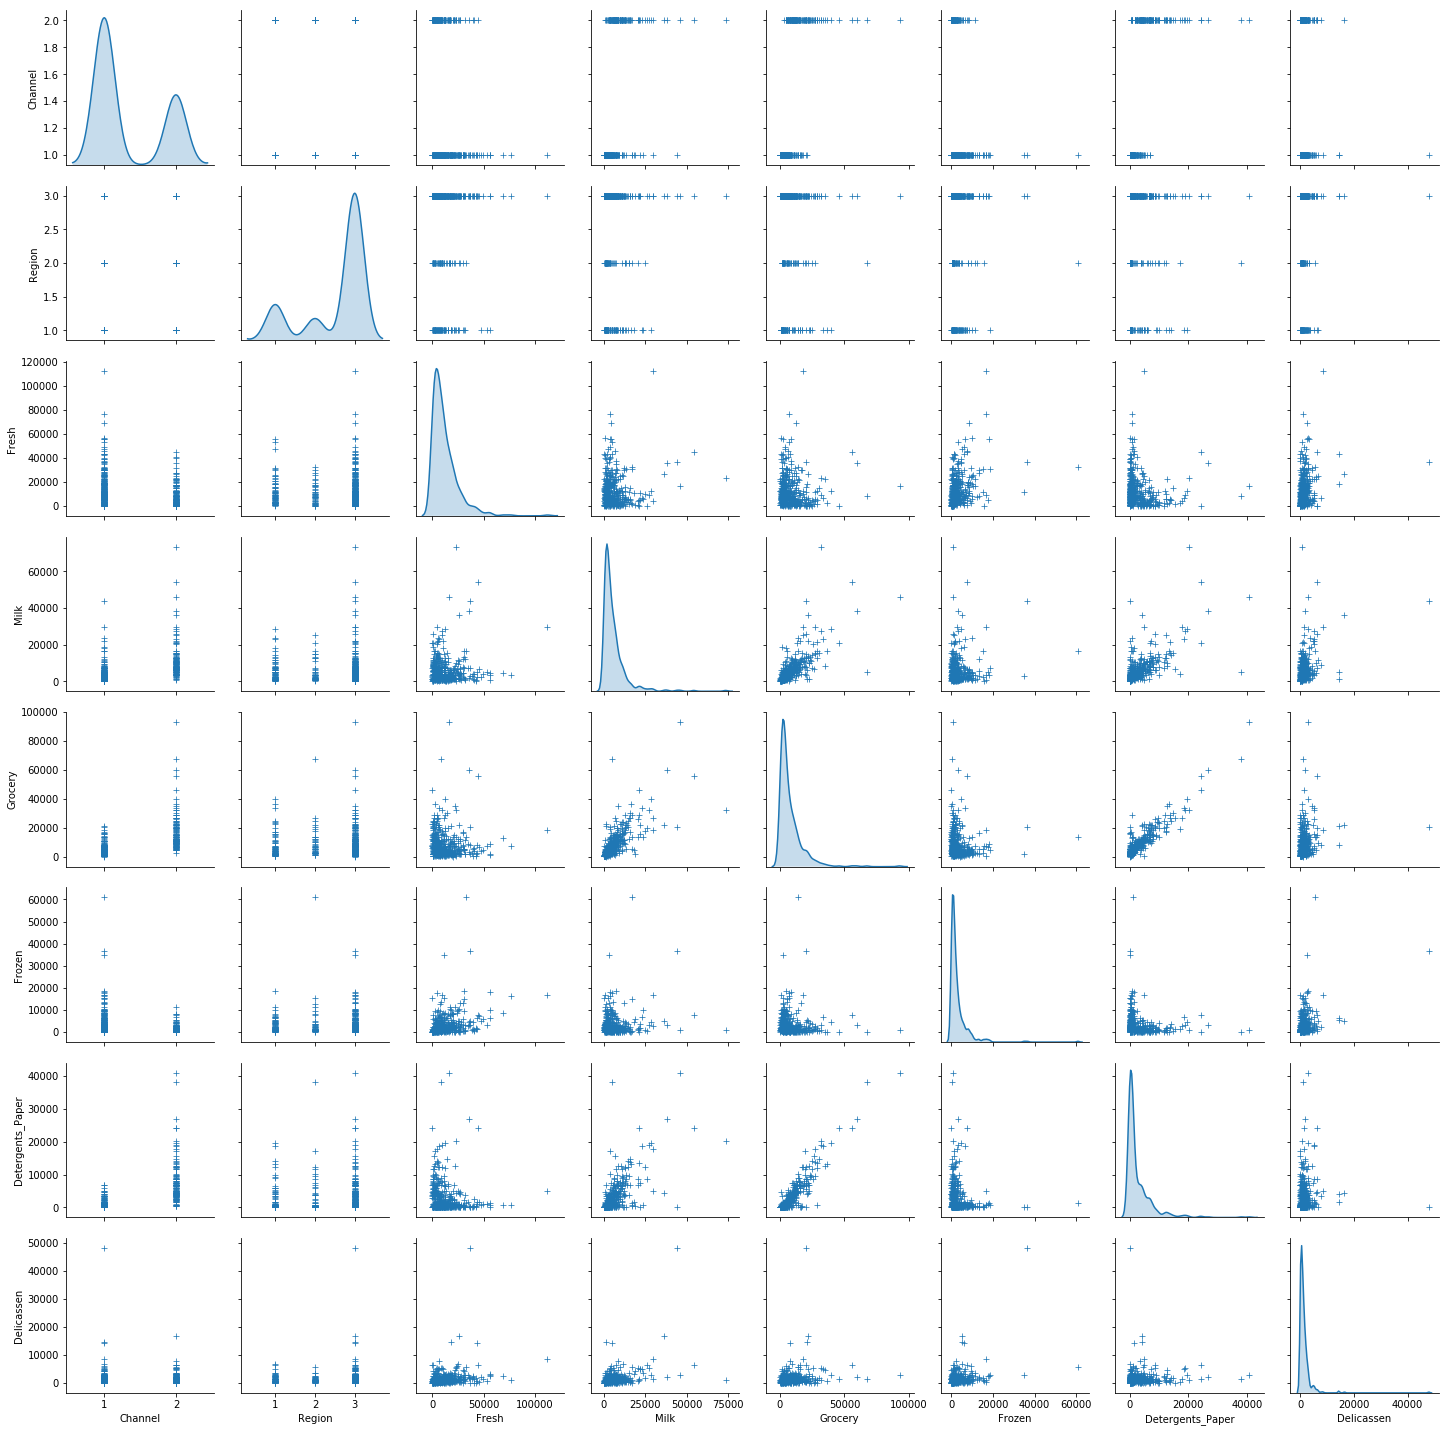

In [6]:
# Inspect the data
# https://seaborn.pydata.org/generated/seaborn.pairplot.html
import seaborn as sns
sns.pairplot(dataset[['Channel',
                       'Region',
                       'Fresh',
                       'Milk',
                       'Grocery',
                       'Frozen',
                       'Detergents_Paper',
                       'Delicassen']], diag_kind='kde', markers="+", diag_kws=dict(shade=True));

In [7]:
stats = dataset.describe().transpose()
display(stats)

,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


### Normalizamos los atributos (_features_)
La normalización de los datos es un paso muy importante previo al entrenamiento de nuestro modelo, ya que los atributos pueden tener rangos y valores muy variados y distintos.

In [8]:
# Creamos una función para realizar la normalización
def norm(x):
  return (x - stats['mean']) / stats['std']

train_ds_norm = norm(train_ds)
test_ds_norm = norm(test_ds)

### KMeans
Utilizamos la librería de _k means_ de _sklearn_ con la mayoría de sus parámetros definidos por defecto.

In [9]:
# Calculamos el k teórico en función de lo revisado en clases
k_teorico = np.sqrt(train_ds_norm.shape[1]/2)
print("K teórico: ", k_teorico)

K teórico:  2.0


Definimos la función _cluster_ que nos permite variar el parámetro de _k_.

In [10]:
def cluster(train_set, n_clusters = 8):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(train_set)
    #WCSS = kmeans.inertia_ #within-cluster sums of squares
    #score = kmeans.score(train_set) #Opposite of the value of X on the K-means objective
    return kmeans

Obtenemos el "gráfico del codo", técnica propuesta para definir un valor óptimo de _k_.

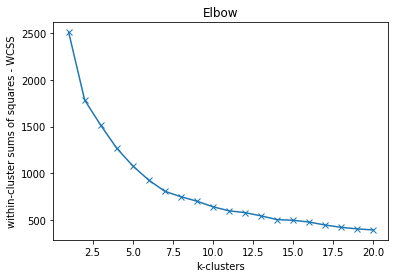

In [11]:
n_clusters = np.arange(1, 21)
WCSS = np.zeros((len(n_clusters)))
i = 0
for n in n_clusters:
    kmeans = cluster(train_ds_norm, n)
    WCSS[i] = kmeans.inertia_ #within-cluster sums of squares
    i = i+1

plt.plot(n_clusters, WCSS, 'x-')
plt.title('Elbow')
plt.xlabel('k-clusters')
plt.ylabel('within-cluster sums of squares - WCSS')

plt.show()

En donde podemos ver que el valor óptimo de k sería entre 4 y 6 clusters. Definimos un valor de k = 5 para obtener los resultados, tanto de las etiquetas (a qué _cluster_ se está agrupando el ejemplo) como de los centroides (centro de cada _cluster_ propuesto).

In [12]:
kmeans = cluster(train_ds_norm, 5)
print("Labels: \n", kmeans.labels_)
print("\nCentroids: \n", kmeans.cluster_centers_)

Labels: 
 [2 3 2 3 1 0 0 4 1 2 0 3 1 1 2 1 0 0 4 1 4 3 2 2 1 1 0 2 0 2 1 0 1 1 2 3 3
 1 1 2 1 1 1 0 1 0 0 2 1 1 1 2 2 0 0 1 1 1 0 1 2 0 1 0 1 0 0 0 1 0 1 1 3 1
 2 2 1 1 1 4 0 1 0 1 3 0 0 1 3 0 0 2 1 1 2 1 2 0 1 2 0 0 2 1 1 1 2 0 1 0 0
 2 1 3 2 2 1 1 1 2 0 0 3 0 1 1 1 4 1 4 1 1 2 0 0 1 0 1 0 0 0 1 2 1 4 2 2 2
 3 0 3 1 1 4 1 1 1 2 1 1 0 1 1 1 1 1 1 2 1 1 1 4 2 1 0 1 1 0 1 2 1 0 1 0 0
 1 1 3 2 1 1 1 1 1 2 1 3 3 1 2 0 1 2 1 1 2 0 0 0 1 1 1 0 1 1 1 2 1 4 2 0 1
 1 1 2 1 1 0 0 0 2 0 1 1 2 1 0 1 2 2 0 0 0 0 2 2 2 2 2 2 0 0 0 3 0 1 2 1 0
 0 1 1 2 1 1 1 0 1 1 2 1 1 3 1 1 1 1 0 0 0 2 1 2 2 2 1 2 0 1 2 2 2 1 2 4 1
 1 3 1 1 0 1 2 1 1 1 1 2 4 0 2 3 0 1 0 1 1 2 1 3 3 1 1 0 2 0 0 1 1 3 0 0 3
 1 1 3 4 1 2 0 0 1 1 1 1 0 0 0 2 0 2 1]

Centroids: 
 [[ 1.4470045   0.24171758 -0.32272081  0.26965878  0.44220916 -0.35224933
   0.45155898 -0.00487459]
 [-0.68951221  0.58999669  0.00844767 -0.39266591 -0.4499611  -0.09542573
  -0.43314606 -0.11332   ]
 [-0.5724428  -1.62153592 -0.0641575  -0.3745315  -0.434155

Ahora, por motivos de visualización se escogieron solamente tres _features_ a graficar: "Fresh", "Milk" y "Grocery". Cambiando los atributos del código propuesto, se puede obtener la gráfica de cualquiera de las otras _features_.

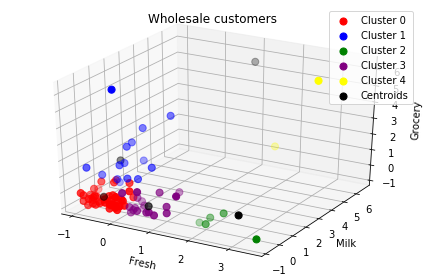

In [13]:
ds_train = train_ds_norm.copy()
ds_train.pop('Channel')
ds_train.pop('Region')
ds_train.pop('Frozen')
ds_train.pop('Detergents_Paper')
ds_train.pop('Delicassen')
#ds_train.pop('Fresh')
#ds_train.pop('Milk')
#ds_train.pop('Grocery')

ds = test_ds_norm.copy()
ds.pop('Channel')
ds.pop('Region')
ds.pop('Frozen')
ds.pop('Detergents_Paper')
ds.pop('Delicassen')
#ds.pop('Fresh')
#ds.pop('Milk')
#ds.pop('Grocery')

# Se crea el modelo en función de las features escogidas
kmeans = cluster(ds_train, 5)
# Se predice a partir del test set
clusters_test = kmeans.predict(ds)

ds['label'] = clusters_test

# Gráfica
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(ds[ds.label==0].Fresh, ds[ds.label==0].Milk, ds[ds.label==0].Grocery, s = 50, c = 'red', label = 'Cluster 0')
ax.scatter(ds[ds.label==1].Fresh, ds[ds.label==1].Milk, ds[ds.label==1].Grocery, s = 50, c = 'blue', label = 'Cluster 1')
ax.scatter(ds[ds.label==2].Fresh, ds[ds.label==2].Milk, ds[ds.label==2].Grocery, s = 50, c = 'green', label = 'Cluster 2')
ax.scatter(ds[ds.label==3].Fresh, ds[ds.label==3].Milk, ds[ds.label==3].Grocery, s = 50, c = 'purple', label = 'Cluster 3')
ax.scatter(ds[ds.label==4].Fresh, ds[ds.label==4].Milk, ds[ds.label==4].Grocery, s = 50, c = 'yellow', label = 'Cluster 4')
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], s = 50, c = 'black', label = 'Centroids')

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

plt.title('Wholesale customers')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

La técnica de clustering es bastante útil para cuando se quieran generar grupos que no tengan una etiqueta (_label_) previa. El valor más importante a decidir es en número de grupos que se quiere obtener, sin embargo para este fin la "técnica del codo" es bastante útil y nos da una buena idea.